9990.0


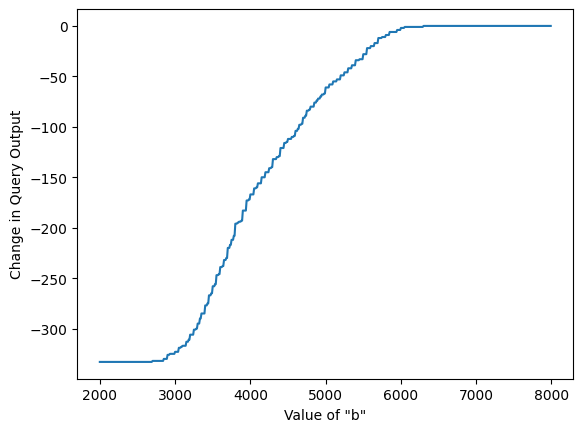

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# preserves epsilon-differential privacy
def above_threshold(queries, df, T, epsilon, on_fail="random"):
    T_hat = T + np.random.laplace(loc=0, scale=2/epsilon)
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale=4/epsilon)
        if q(df) + nu_i >= T_hat:
            return idx

    # Handle failure case
    if on_fail == "random":
        # if the algorithm "fails", return a random index
        # more convenient in certain use cases
        return random.randint(0, len(queries) - 1)
    else:
        return None


def age_sum_query(df, U, var):
    return df[var].clip(lower=0, upper=U).sum()


def create_query(b, var):
    return lambda df: age_sum_query(df, b, var) - age_sum_query(df, b + 1, var)


data = sns.load_dataset("penguins").dropna()
var = "body_mass_g"

print(age_sum_query(data, 30, var))

bs = range(2000, 8000, 10)
query_results = [age_sum_query(data, b, var) - age_sum_query(data, b + 1, var) for b in bs]
plt.xlabel('Value of "b"')
plt.ylabel('Change in Query Output')
plt.plot(bs, query_results)
plt.show()


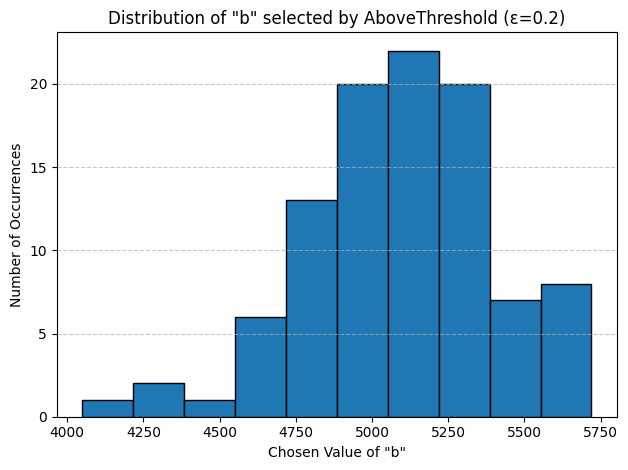

In [11]:
queries = [create_query(b, var) for b in bs]
epsilon = .2


plt.hist(
    [bs[above_threshold(queries, data, 0, epsilon)] for _ in range(100)],  # pour contrôler les bornes des barres
    edgecolor='black'
)
plt.xlabel('Chosen Value of "b"')
plt.ylabel('Number of Occurrences')
plt.title(f'Distribution of "b" selected by AboveThreshold (ε={epsilon})')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [12]:
import polars as pl
import os 

storage_options = {
    "aws_access_key_id": os.environ["AWS_ACCESS_KEY_ID"],
    "aws_secret_access_key": os.environ["AWS_SECRET_ACCESS_KEY"],
    "aws_session_token": os.environ["AWS_SESSION_TOKEN"],
    "endpoint_url": "https://minio.lab.sspcloud.fr",
}

source = "s3://gferey/diffusion/synthetic-filo/METRO/population/population_METRO.parquet"


df = pl.read_parquet(source, storage_options=storage_options)

1156632948896.3967


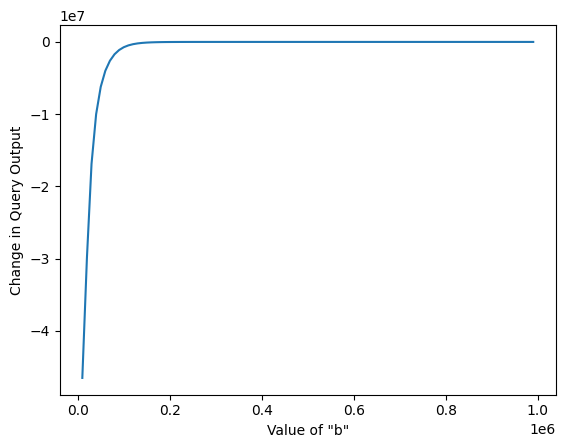

In [15]:
data = df
var = "NIVEAU_VIE"

def age_sum_query(df: pl.DataFrame, U: float, var: str) -> float:
    return df.with_columns(
        pl.col(var).clip(lower_bound=0, upper_bound=U).alias("clipped")
    )["clipped"].sum()


def create_query(b, var):
    return lambda df: age_sum_query(df, b, var) - age_sum_query(df, b + 1, var)

print(age_sum_query(data, 30000, var))

bs = range(10_000, 1_000_000, 10000)
query_results = [age_sum_query(data, b, var) - age_sum_query(data, b + 1, var) for b in bs]
plt.xlabel('Value of "b"')
plt.ylabel('Change in Query Output')
plt.plot(bs, query_results)
plt.show()


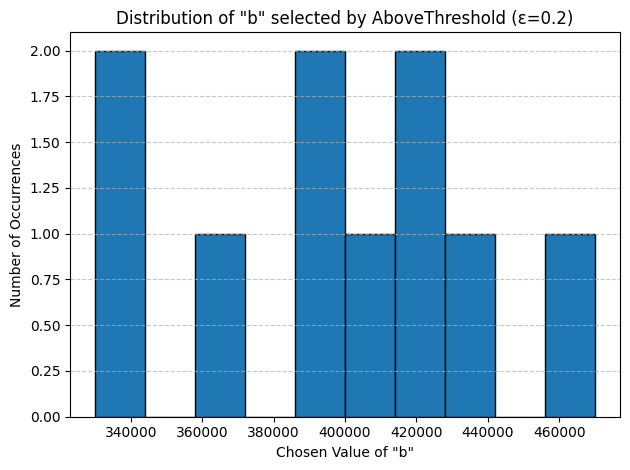

In [16]:
queries = [create_query(b, var) for b in bs]
epsilon = .2


plt.hist(
    [bs[above_threshold(queries, data, 0, epsilon)] for _ in range(10)],  # pour contrôler les bornes des barres
    edgecolor='black'
)
plt.xlabel('Chosen Value of "b"')
plt.ylabel('Number of Occurrences')
plt.title(f'Distribution of "b" selected by AboveThreshold (ε={epsilon})')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
